In [1]:
# pip install POT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import warnings
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import multivariate_normal
from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import percentileofscore
from itertools import product
import ot
from dim3_OT_inter import train

In [2]:
def Gauss_copula_cdf(u, cor):
    x = norm.ppf(u)
    output = multivariate_normal.cdf(x, mean=np.zeros(3), cov=cor)
    return output

def discrete_gausscopula(N, cor):
    C = np.zeros((N,N,N))
    for i in range(N):
        for j in range(N):
            for k in range(N):
                C[k,i,j] = Gauss_copula_cdf(u=np.array([(k+1)/N, (i+1)/N, (j+1)/N]), cor=cor)
    return C

def discrete_pdf(N, C):
    C0 = np.zeros((N+1,N+1,N+1))
    C0[1:,1:,1:] = C
    A = np.zeros((N,N,N))
    # C[0,0,0] = C[0,0,0]
    for i in range(N):
        for j in range(N):
            for k in range(N):
                A[k,i,j] = (C0[k+1,i+1,j+1] - C0[k+1,i,j+1] - C0[k+1,i+1,j] - C0[k,i+1,j+1] + C0[k+1,i,j] + C0[k,i,j+1] + C0[k,i+1,j] - C0[k,i,j])#*N**3
    return A

def margin(A):
    N = len(A)
    a = np.zeros(3*N)
    for i in range(N):
        a[i] = A[i,:,:].sum()
    for i in range(N):
        a[N+i] = A[:,i,:].sum()
    for i in range(N):
        a[2*N+i] = A[:,:,i].sum()
    return a

In [3]:
def L2_distance(n):
    center_row = np.arange(1, 2*n, 2, dtype=np.float64)
    centers_li = np.array(list(product(center_row,repeat=3)))
    cost_matrix = ot.dist(centers_li / (2*n),centers_li / (2*n), metric='sqeuclidean', p=2, w=None) 
    return cost_matrix

def L1_distance(n):
    center_row = np.arange(1, 2*n, 2, dtype=np.float64)
    centers_li = np.array(list(product(center_row,repeat=3)))
    cost_matrix = ot.dist(centers_li / (2*n),centers_li / (2*n), metric='cityblock', p=2, w=None) 
    return cost_matrix

def normalize(u):
    return u / np.sum(u)

In [4]:
def transfer_matrix_i(i,j,k,i0,j0,k0):
    Z = np.zeros((N,N,N))
    Z[k,i,j] -= 1
    Z[k0,i0,j0] -= 1
    Z[k,i0,j] += 1
    Z[k0,i,j0] += 1
    return Z

In [5]:
def transfer_matrix_j(i,j,k,i0,j0,k0):
    Z = np.zeros((N,N,N))
    Z[k,i,j] -= 1
    Z[k0,i0,j0] -= 1
    Z[k,i,j0] += 1
    Z[k0,i0,j] += 1
    return Z

In [6]:
def i_row_trans(i,j,k,i0,j0,k0,A0,A_path,a_list,a):
    A0_copy = A0.copy()
    A0_copy[k,:,:] = - 1
    a_temp = [a]
    sign = np.sign(i0 - i)
    index_j = []
    index_k = []
    for tmpi in range(i+sign, i0, sign):
        value = np.max(A0_copy[:, tmpi, :])
        tmpk, tmpj = np.unravel_index(np.argmax(A0_copy[:, tmpi, :]), A0_copy[:, tmpi, :].shape)
        index_j.append(tmpj)
        index_k.append(tmpk)
        a_temp.append(value)
    a_local = min(a_temp)
    num_rep = a // a_local
    r = a - num_rep * a_local

    for temp in range(int(num_rep)):
        for tmpi in range(i+sign, i0, sign):
            trans_Z = a_local * transfer_matrix_i(tmpi-sign,j,k,tmpi,index_j[abs(tmpi-i)-1],index_k[abs(tmpi-i)-1])
            A0 = A0 + trans_Z
            A_path.append(A0)
            a_list.append(a_local)
        trans_Z = a_local * transfer_matrix_i(i0-sign,j,k,i0,j0,k0)
        A0 = A0 + trans_Z
        A_path.append(A0)
        a_list.append(a_local)
        for tmpi in range(i0-sign, i, -sign):
            if index_j[abs(tmpi-i)-1] != j0 or index_k[abs(tmpi-i)-1] != k0:
                trans_Z = a_local * transfer_matrix_i(tmpi, j0, k0, tmpi-sign, index_j[abs(tmpi-i)-1],index_k[abs(tmpi-i)-1])
                A0 = A0 + trans_Z
                A_path.append(A0)
                a_list.append(a_local)
                
    if r>10**(-6):
        for tmpi in range(i+sign, i0, sign):
            trans_Z = r * transfer_matrix_i(tmpi-sign,j,k,tmpi,index_j[abs(tmpi-i)-1],index_k[abs(tmpi-i)-1])
            A0 = A0 + trans_Z
            A_path.append(A0)
            a_list.append(a_local)
        trans_Z = r * transfer_matrix_i(i0-sign,j,k,i0,j0,k0)
        A0 = A0 + trans_Z
        A_path.append(A0)
        a_list.append(r)
        for tmpi in range(i0-sign, i, -sign):
            if index_j[abs(tmpi-i)-1] != j0 or index_k[abs(tmpi-i)-1] != k0:
                trans_Z = r * transfer_matrix_i(tmpi, j0, k0, tmpi-sign, index_j[abs(tmpi-i)-1],index_k[abs(tmpi-i)-1])
                A0 = A0 + trans_Z
                A_path.append(A0)
                a_list.append(r)
    return A0, A_path, a_list

In [7]:
def j_row_trans(i,j,k,i0,j0,k0,A0,A_path,a_list,a):
    A0_copy = A0.copy()
    A0_copy[k,:,:] = - 1
    a_temp = [a]
    sign = np.sign(j0 - j)
    index_i = []
    index_k = []
    for tmpj in range(j+sign, j0, sign):
        value = np.max(A0_copy[:, :, tmpj])
        tmpk, tmpi = np.unravel_index(np.argmax(A0_copy[:, :, tmpj]), A0_copy[:, :, tmpj].shape)
        index_i.append(tmpi)
        index_k.append(tmpk)
        a_temp.append(value)
    a_local = min(a_temp)
    
    num_rep = a // a_local
    r = a - num_rep * a_local
    
    for temp in range(int(num_rep)):
        for tmpj in range(j+sign, j0, sign):
            trans_Z = a_local * transfer_matrix_j(i,tmpj-sign,k,index_i[abs(tmpj-j)-1],tmpj,index_k[abs(tmpj-j)-1])
            A0 = A0 + trans_Z
            A_path.append(A0)
            a_list.append(a_local)
        trans_Z = a_local * transfer_matrix_j(i,j0-sign,k,i0,j0,k0)
        A0 = A0 + trans_Z
        A_path.append(A0)
        a_list.append(a_local)
        for tmpj in range(j0-sign, j, -sign):
            if index_i[abs(tmpj-j)-1] != i0 or index_k[abs(tmpj-j)-1] != k0:
                trans_Z = a_local * transfer_matrix_j(i0, tmpj, k0, index_i[abs(tmpj-j)-1], tmpj-sign,index_k[abs(tmpj-j)-1])
                A0 = A0 + trans_Z
                A_path.append(A0)
                a_list.append(a_local)
    if r>10**(-N):
        for tmpj in range(j+sign, j0, sign):
            trans_Z = r * transfer_matrix_j(i,tmpj-sign,k,index_i[abs(tmpj-j)-1],tmpj,index_k[abs(tmpj-j)-1])
            A0 = A0 + trans_Z
            A_path.append(A0)
            a_list.append(r)
        trans_Z = r * transfer_matrix_j(i,j0-sign,k,i0,j0,k0)
        A0 = A0 + trans_Z
        A_path.append(A0)
        a_list.append(r)
        for tmpj in range(j0-sign, j, -sign):
            if index_i[abs(tmpj-j)-1] != i0 or index_k[abs(tmpj-j)-1] != k0:
                trans_Z = r * transfer_matrix_j(i0, tmpj, k0, index_i[abs(tmpj-j)-1], tmpj-sign,index_k[abs(tmpj-j)-1])
                A0 = A0 + trans_Z
                A_path.append(A0)
                a_list.append(r)
    return A0, A_path, a_list

In [8]:
def get_path(A0, A1, epsilon_0, a_value):
    Z = A1 - A0
    # A_path = [A0]
    A_path = []
    size = len(A0)
    k = 0
    a_list = []
    while k < size:
        if np.min(Z[k,:,:]) < -epsilon_0*(k+1)*a_value:
            i,j = np.unravel_index(np.argmin(Z[k,:,:]), Z[k,:,:].shape)
            i0, j0 = np.unravel_index(np.argmax(Z[k,:,:]), Z[k,:,:].shape)
            if j == j0:
                kk,jj = np.unravel_index(np.argmin(Z[k:,i0,:]), Z[k:,i0,:].shape)
                kk = kk + k
                a = min(-Z[k,i,j], Z[k,i0,j], -Z[kk,i0,jj])
                if abs(i-i0) == 1:
                    transZ = a * transfer_matrix_i(i,j,k,i0,jj,kk)
                    Z = Z - transZ
                    A0 = A0 + transZ
                    A_path.append(A0)
                    a_list.append(a)
                else: 
                    A0, A_path, a_list = i_row_trans(i,j,k,i0,jj,kk,A0,A_path,a_list,a)
                    Z = Z - a * transfer_matrix_i(i,j,k,i0,jj,kk)
            elif i == i0:
                kk,ii = np.unravel_index(np.argmin(Z[k:,:,j0]), Z[k:,:,j0].shape)
                kk = kk + k
                a = min(-Z[k,i,j], Z[k,i0,j0], -Z[kk,ii,j0])
                # print(a)
                if abs(j-j0) == 1:
                    transZ = a * transfer_matrix_j(i,j,k,ii,j0,kk)
                    Z = Z - transZ
                    A0 = A0 + transZ
                    A_path.append(A0)
                    a_list.append(a)
                else:
                    A0, A_path, a_list = j_row_trans(i,j,k,ii,j0,kk,A0,A_path,a_list,a)
                    Z = Z - a * transfer_matrix_j(i,j,k,ii,j0,kk)
            elif i != i0 and j != j0:
                kk, jj = np.unravel_index(np.argmin(Z[k:,i0,:]), Z[k:,i0,:].shape)
                kk = kk + k
                kkk,iii = np.unravel_index(np.argmin(Z[k:,:,j0]), Z[k:,:,j0].shape)
                kkk = kkk + k
                if iii==i0 and jj==j0 and kk==kkk:
                    a = min(-Z[k,i,j], Z[k,i0,j0], -Z[kk,i0,jj]/2)
                else: 
                    a = min(-Z[k,i,j], Z[k,i0,j0], -Z[kk,i0,jj], -Z[kkk,iii,j0])
                A0, A_path, a_list = i_row_trans(i,j,k,i0,jj,kk,A0,A_path,a_list,a)
                Z = Z - a * transfer_matrix_i(i,j,k,i0,jj,kk)
                A0, A_path, a_list = j_row_trans(i0,j,k,iii,j0,kkk,A0,A_path,a_list,a)
                Z = Z - a * transfer_matrix_j(i0,j,k,iii,j0,kkk)
        else:
            k = k + 1
    return A0, a_list, A_path

In [9]:
cor0 = np.array([[1,0.2,0.4], 
                [0.2,1,0.6],
                [0.4,0.6,1]])
cor1 = np.array([[1,-0.2,0.8],
                 [-0.2,1,0.1],
                 [0.8,0.1,1]])
N = 20
# N = 5 
C_0 = discrete_gausscopula(N, cor0)
C_1 = discrete_gausscopula(N, cor1)
A_0 = discrete_pdf(N, C_0)
A_1 = discrete_pdf(N, C_1)
margin(A_0), margin(A_1), A_0.all()>=0, A_1.all()>0

(array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
        0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
        0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
        0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
        0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
        0.05, 0.05, 0.05, 0.05, 0.05]),
 array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
        0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
        0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
        0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
        0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
        0.05, 0.05, 0.05, 0.05, 0.05]),
 np.True_,
 np.True_)

In [11]:
A_result, a_list, A_path = get_path(A_0, A_1, epsilon_0=10**(-15), a_value=1000)
np.abs(A_result - A_1).max()

np.float64(4.110682508360469e-11)

In [12]:
for i in range(len(A_path)):
    assert np.abs(margin(A_path[i]) - np.ones(N*3)/N).max() < 10**(-6)
    assert A_path[i].all() >= 0

In [13]:
a_all = [0] + a_list
A_path = [A_0] + A_path
num_interp = 100
a_sum_list = np.cumsum(a_all)
b = [np.sum(a_list)/num_interp * i for i in range(num_interp)]
avarage_indices = np.searchsorted(a_sum_list, b)
avarage_indices = np.append(avarage_indices, len(a_all)-1)
A_equal_effort = [A_path[i] for i in avarage_indices]

A_path_0 = A_equal_effort[0]
A_path_1 = A_equal_effort[num_interp//5]
A_path_2 = A_equal_effort[2*num_interp//5]
A_path_3 = A_equal_effort[3*num_interp//5]
A_path_4 = A_equal_effort[4*num_interp//5]
A_path_5 = A_equal_effort[5*num_interp//5]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


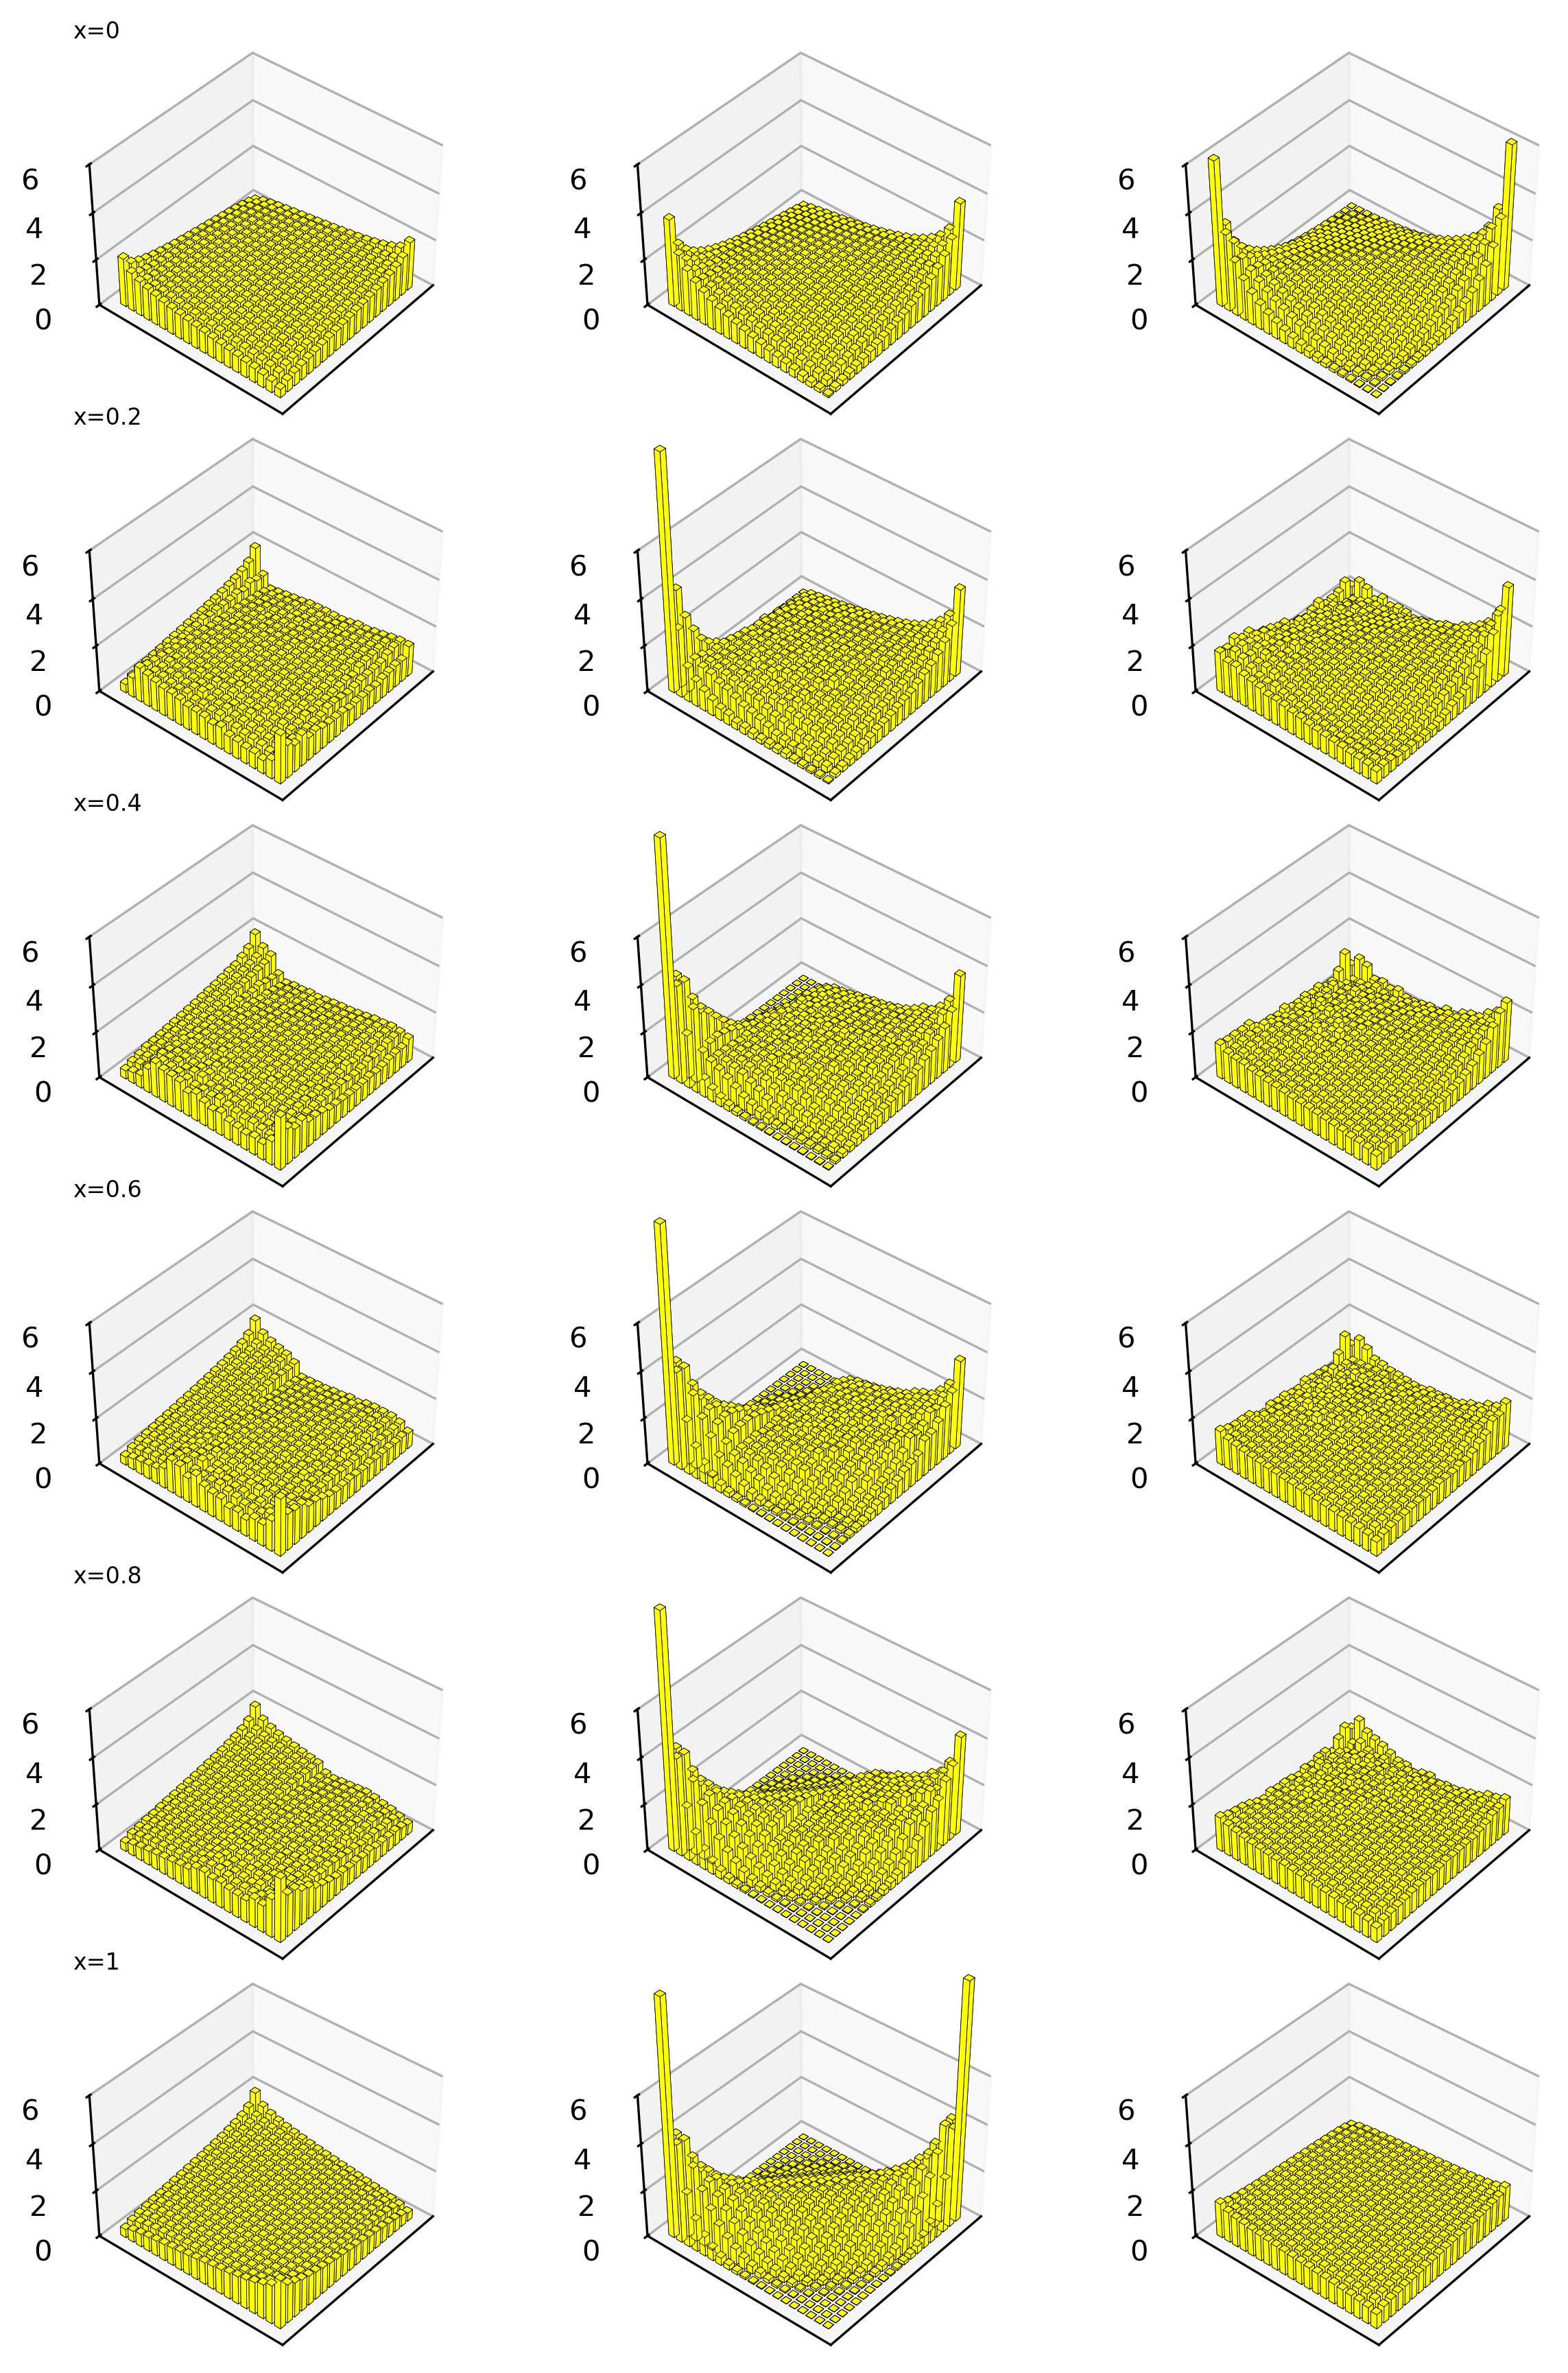

In [14]:
fig, axes = plt.subplots(
    6, 3,
    figsize=(8.27, 11.69),      # A4 paper
    subplot_kw={'projection': '3d'},
    constrained_layout=False,  
    dpi=300
)

plt.subplots_adjust(
    wspace=0.02,  
    hspace=0.02,  
    top=0.98,    
    bottom=0.02,
    left=0.02,
    right=0.98
)

matrix_list = [A_path_0, A_path_1, A_path_2, A_path_3, A_path_4, A_path_5]
titles = ['x=0'] + ['x=0.2', 'x=0.4', 'x=0.6', 'x=0.8'] + ['x=1']
for i in range(6):
    matrix = matrix_list[i]
    f12 = matrix.sum(axis=2) * N**2
    f13 = matrix.sum(axis=1) * N**2
    f23 = matrix.sum(axis=0) * N**2
    pairs = {(0):f12, (1):f13, (2):f23}
    for (j), fij in pairs.items():
        x, y = np.meshgrid(np.arange(fij.shape[0]), np.arange(fij.shape[1]))
        x = x.flatten()
        y = y.flatten()
        z = np.zeros_like(x)
        dx = dy = 0.7
        dz = fij.flatten()
        axes[i,j].bar3d(x, y, z, dx, dy, dz, shade=False, color='yellow', edgecolor='black', linewidth=0.2)
        axes[i,j].view_init(elev=40, azim=40)
        axes[i,j].invert_xaxis()
        # axes[i,j].invert_yaxis()
        axes[i,j].set_xticks([]) 
        axes[i,j].set_yticks([])
        axes[i,j].set_zlim(0, 6)
    axes[i, 0].set_title(titles[i], fontsize=8, pad=-20, loc='left')
# plt.tight_layout(pad=0.1, w_pad=0.2, h_pad=0.2)
plt.savefig('Fig/dim3_direct_inter.eps', format='eps')
plt.savefig('Fig/dim3_direct_inter-eps-converted-to.pdf', format='pdf')
plt.show()

In [15]:
len(a_all), len(A_path), sum(a_all)

(251260, 251260, np.float64(6.307761369405537))

In [16]:
wasseretrin1_A0 = np.zeros(num_interp+1)
wasseretrin1_A1 = np.zeros(num_interp+1)
wasseretrin2_A0 = np.zeros(num_interp+1)
wasseretrin2_A1 = np.zeros(num_interp+1)
temp_A0 = np.ravel(A_0)
temp_A1 = np.ravel(A_1)
cost_1 = L1_distance(N)
cost_2 = L2_distance(N)
for i in range(num_interp+1):
    wasseretrin1_A0[i] = ot.emd2(np.ravel(A_equal_effort[i]), temp_A0, cost_1)
    wasseretrin1_A1[i] = ot.emd2(np.ravel(A_equal_effort[i]), temp_A1, cost_1)
    wasseretrin2_A0[i] = ot.emd2(np.ravel(A_equal_effort[i]), temp_A0, cost_2)
    wasseretrin2_A1[i] = ot.emd2(np.ravel(A_equal_effort[i]), temp_A1, cost_2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


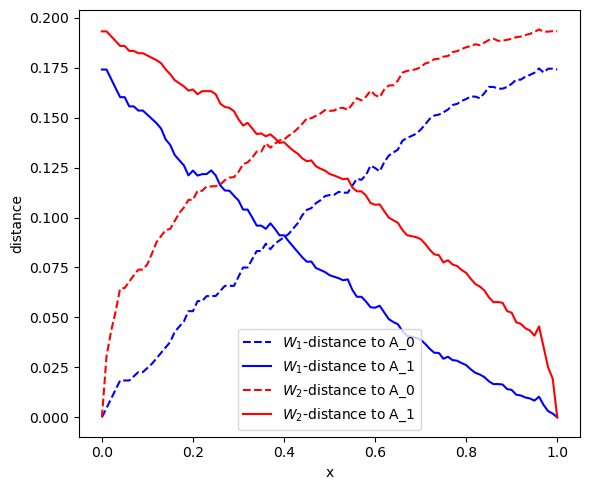

In [17]:
fig, ax = plt.subplots(1, figsize=(6, 5))
x = np.linspace(0, 1, num_interp+1)
ax.plot(x, wasseretrin1_A0, label=r'$W_1$-distance to A_0', color='blue', linestyle='--')
ax.plot(x, wasseretrin1_A1, label=r'$W_1$-distance to A_1', color='blue')
ax.plot(x, np.sqrt(wasseretrin2_A0), label=r'$W_2$-distance to A_0', color='red', linestyle='--')
ax.plot(x, np.sqrt(wasseretrin2_A1), label=r'$W_2$-distance to A_1', color='red')
# ax.set_title(r'Wasserstein distance')
ax.set_xlabel('x')
ax.set_ylabel('distance')
ax.legend()
plt.tight_layout()
plt.savefig('Fig/dim3_Wasser_direct.eps', format='eps')
plt.savefig('Fig/dim3_Wasser_direct-eps-converted-to.pdf', format='pdf')
plt.show()

In [10]:
Q = 20
N1 = N
N2 = N
N3 = N
L = 1
sigma=85
tau = 0.99 / (sigma*L)
iter_num = 2000
theta = 1
epsilon = 10**(-15)
U,V = train(A_0, A_1, Q, N1, N2, N3, iter_num, sigma, tau, theta, epsilon)

In [11]:
def convert_to_copula(A):
    
    A = A/np.sum(A)
    A = np.insert(A, 0, 0, axis=0)
    A = np.insert(A, 0, 0, axis=1)
    A = np.insert(A, 0, 0, axis=2)
    n = len(A)
    f_1, f_2, f_3 = margin(A).reshape((3,n))
    F_1 = np.cumsum(f_1)
    F_2 = np.cumsum(f_2)
    F_3 = np.cumsum(f_3)
    
    x = np.linspace(0, 1, n)
    F_1_inv = interp1d(F_1, x, kind='linear')
    F_2_inv = interp1d(F_2, x, kind='linear')
    F_3_inv = interp1d(F_3, x, kind='linear')
    
    H = np.cumsum(np.cumsum(np.cumsum(A, axis=0), axis=1), axis=2)
    h = RegularGridInterpolator((x, x, x), H)
    
    x = np.linspace(0, 1-10**(-10), n)
    X, Y, Z = np.meshgrid(F_1_inv(x), F_2_inv(x), F_3_inv(x))
    copula_matrix = h((X,Y,Z)).transpose(1,0,2)
    copula_density = copula_matrix[1:,1:,1:]-copula_matrix[1:,1:,:-1]-copula_matrix[1:,:-1,1:] - copula_matrix[:-1,1:,1:]+copula_matrix[1:,:-1,:-1]+\
                 copula_matrix[:-1,1:,:-1]+copula_matrix[:-1,:-1,1:]-copula_matrix[:-1,:-1,:-1]
    
    return copula_density

In [12]:
copula_inter = np.zeros((Q+1,N1, N2, N3))
for i in range(Q+1):
    copula_inter[i,:,:,:] = convert_to_copula(U.M[0][i])
AA0 = copula_inter[0,:,:]
A_path_all = [AA0]
a_all = [0]
i = 0
n_index_list = [0]
n_index = 0
while i < Q:
    # print(i)
    _, a_list, A_path =  get_path(copula_inter[i], copula_inter[i+1], epsilon_0=10**(-8), a_value=300)
    # _, a_list, A_path =  get_path(copula_inter[i], copula_inter[i+1], epsilon_0=10**(-10), a_value=100)  # for N=5
    n_index += len(a_list)
    n_index_list.append(n_index)
    a_all = a_all + a_list
    A_path_all = A_path_all + A_path
    i += 1

In [ ]:
if (U.M[0]).any() < -10**(-7):
    warnings.warn('Negative problem')
U.M[0][U.M[0] < 0] = 0

t_list_plt = np.array([0, Q//5, (Q*2)//5, (Q*3)//5, (Q*4)//5, Q])
A_path_0 = convert_to_copula(U.M[0][t_list_plt[0]])
A_path_1 = convert_to_copula(U.M[0][t_list_plt[1]])
A_path_2 = convert_to_copula(U.M[0][t_list_plt[2]])
A_path_3 = convert_to_copula(U.M[0][t_list_plt[3]])
A_path_4 = convert_to_copula(U.M[0][t_list_plt[4]])
A_path_5 = convert_to_copula(U.M[0][t_list_plt[5]])

# fig, axes = plt.subplots(6, 3, figsize=(15, 30), subplot_kw={'projection': '3d'})
fig, axes = plt.subplots(
    6, 3,
    figsize=(8.27, 11.69),      # A4 paper
    subplot_kw={'projection': '3d'},
    constrained_layout=False,  
    dpi=300
)

plt.subplots_adjust(
    wspace=0.02,  
    hspace=0.02,  
    top=0.98,    
    bottom=0.02,
    left=0.02,
    right=0.98
)
# plt.subplots_adjust(wspace=0.2, hspace=0.05)
matrix_list = [A_path_0, A_path_1, A_path_2, A_path_3, A_path_4, A_path_5]
titles = ['x=0'] + ['x=0.2', 'x=0.4', 'x=0.6', 'x=0.8'] + ['x=1']
for i in range(6):
    matrix = matrix_list[i] 
    f12 = matrix.sum(axis=2) * N**2
    f13 = matrix.sum(axis=1) * N**2
    f23 = matrix.sum(axis=0) * N**2
    pairs = {(0):f12, (1):f13, (2):f23}
    for (j), fij in pairs.items():
        x, y = np.meshgrid(np.arange(fij.shape[0]), np.arange(fij.shape[1]))
        x = x.flatten()
        y = y.flatten()
        z = np.zeros_like(x)
        dx = dy = 0.7
        dz = fij.flatten()
        axes[i,j].bar3d(x, y, z, dx, dy, dz, shade=False, color='yellow', edgecolor='black', linewidth=0.2)
        axes[i,j].view_init(elev=40, azim=40)
        axes[i,j].invert_xaxis()
        # axes[i,j].invert_yaxis()
        axes[i,j].set_xticks([]) 
        axes[i,j].set_yticks([])
        axes[i,j].set_zlim(0, 6)
    axes[i, 0].set_title(titles[i], fontsize=8, pad=-20, loc='left')
plt.savefig('Fig/dim3_OT_inter.eps', format='eps')
plt.savefig('Fig/dim3_OT_inter-eps-converted-to.pdf', format='pdf')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [ ]:
len(a_all), len(A_path_all), sum(a_all)

In [23]:
num_interp = 20
sum_a_all = np.cumsum(a_all)
c = np.linspace(0, np.sum(a_all[: n_index_list[1]]),num_interp+1)[:-1]
avarage_indices = np.searchsorted(sum_a_all, c)
for i in range(1,Q):
    c = np.linspace(np.sum(a_all[: n_index_list[i]]), np.sum(a_all[: n_index_list[i+1]]),num_interp+1)[:-1]
    temp = np.searchsorted(sum_a_all, c)
    avarage_indices = np.concatenate((avarage_indices, temp))
avarage_indices = np.append(avarage_indices, n_index_list[-1])

A_equal_effort_plot = [A_path_all[i] for i in avarage_indices]
wasseretrin2_copula_A1 = np.zeros(Q*num_interp+1)
wasseretrin2_copula_A0 = np.zeros(Q*num_interp+1)
wasseretrin1_copula_A1 = np.zeros(Q*num_interp+1)
wasseretrin1_copula_A0 = np.zeros(Q*num_interp+1)
temp_A0 = np.ravel(A_0)
temp_A1 = np.ravel(A_1)
cost_1 = L1_distance(N)
cost_2 = L2_distance(N)
for i in range(Q*num_interp+1):
    A = np.ravel(A_equal_effort_plot[i])
    # print(A.sum())
    # a = A.sum()-N
    # if a<0:
    #     A[np.argmin(A)] -= a
    # else:
    #     A[np.argmax(A)] -= a
    # A[A < 0] = 0
    wasseretrin1_copula_A0[i] = ot.emd2(A, temp_A0, cost_1) 
    wasseretrin1_copula_A1[i] = ot.emd2(A, temp_A1, cost_1) 
    wasseretrin2_copula_A0[i] = ot.emd2(A, temp_A0, cost_2)
    wasseretrin2_copula_A1[i] = ot.emd2(A, temp_A1, cost_2) 

wass2_intermatr_A1 = np.zeros(Q+1)
wass2_intermatr_A0 = np.zeros(Q+1)
wass1_intermatr_A1 = np.zeros(Q+1)
wass1_intermatr_A0 = np.zeros(Q+1)
for i in range(Q+1):
    A = np.ravel(U.M[0][i])
    # a = A.sum()-N
    #         if a<0:
    #             A[np.argmin(A)] -= a
    #         else:
    #             A[np.argmax(A)] -= a
    wass2_intermatr_A0[i] = np.sqrt(ot.emd2(A, temp_A0, cost_2))
    wass2_intermatr_A1[i] = np.sqrt(ot.emd2(A, temp_A1, cost_2))
    wass1_intermatr_A0[i] = ot.emd2(A, temp_A0, cost_1)
    wass1_intermatr_A1[i] = ot.emd2(A, temp_A1, cost_1)

In [24]:
# i = Q*num_interp
# A = np.ravel(A_equal_effort_plot[i])
# ot.bregman.sinkhorn2(A, temp_A1, cost_2, reg=0.0001, method='sinkhorn', numItermax=1000, stopThr=1e-09) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


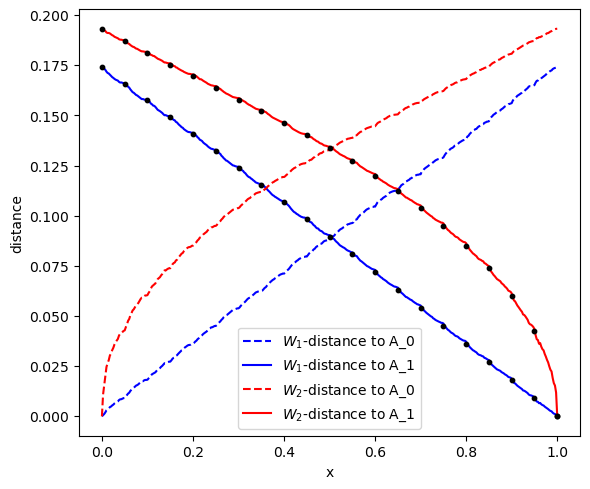

In [26]:
fig, ax = plt.subplots(1, figsize=(6, 5))
x = np.linspace(0, 1, Q*num_interp+1)
ax.plot(x, wasseretrin1_copula_A0, label=r'$W_1$-distance to A_0', color='blue', linestyle='--')
ax.plot(x, wasseretrin1_copula_A1, label=r'$W_1$-distance to A_1', color='blue')
ax.plot(x, np.sqrt(wasseretrin2_copula_A0), label=r'$W_2$-distance to A_0', color='red', linestyle='--')
ax.plot(x, np.sqrt(wasseretrin2_copula_A1), label=r'$W_2$-distance to A_1', color='red')
ax.scatter(np.linspace(0, 1, Q+1), wass2_intermatr_A1, color='black', zorder=5, s=10)
ax.scatter(np.linspace(0, 1, Q+1), wass1_intermatr_A1, color='black', zorder=5, s=10)
# ax.set_title(r'Wasserstein distance')
ax.set_xlabel('x')
ax.set_ylabel('distance')
ax.legend()
plt.tight_layout()
plt.savefig('Fig/dim3_Wasser_OT.eps', format='eps')
plt.savefig('Fig/dim3_Wasser_OT-eps-converted-to.pdf', format='pdf')
plt.show()